In [1]:
# Always check current input path
import os
os.listdir(r"C:\Users\joshu\Desktop\imageClassifier")

['.ipynb_checkpoints',
 'dataset',
 'index.html',
 'logs',
 'modelApi.ipynb',
 'ModelApii.ipynb',
 'static',
 'WebCrawler.ipynb']

In [4]:
# Part 1 - Preparing data
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2)


test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(r'C:\Users\joshu\Desktop\imageClassifier\dataset\training_set',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 shuffle=True,
                                                 seed=42)

testing_set = test_datagen.flow_from_directory(r'C:\Users\joshu\Desktop\imageClassifier\dataset\testing_set',
                                            target_size = (128, 128),
                                            batch_size = 1,
                                            shuffle=False,
                                            class_mode = 'binary')


Found 204 images belonging to 2 classes.
Found 95 images belonging to 2 classes.


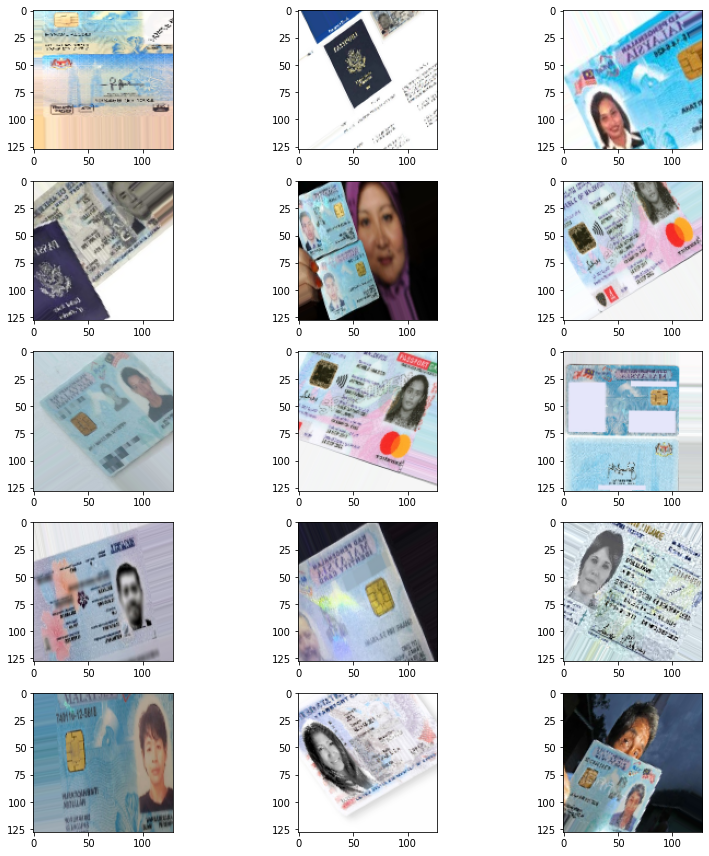

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# print 15 sample training image
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in training_set:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [3]:
# Define the constants

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3
INPUT_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
EPOCHS = 35
POOL_SIZE = 2
LR = 0.001

In [6]:
#Building the model
import time

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

# Use EarlyStopping and ReduceLROnPlateau
# when train, it keep testing set separetely and if the error is not improve for 5 times, training stop
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

# Save the best weight for epoch checkpoint
checkpointer = ModelCheckpoint(filepath = "best_weight.hdf5", monitor='val_loss', verbose=0, save_best_only=True)

In [7]:
from tensorflow.keras.optimizers import Adam


STEP_SIZE_TRAIN = training_set.n//training_set.batch_size
STEP_SIZE_TEST = testing_set.n//testing_set.batch_size

# CONV_LAYERS = [1, 2, 3]
# LAYER_SIZES = [32, 64, 128]
# DENSE_LAYERS = [0, 1, 2]

CONV_LAYERS = [2]
LAYER_SIZES = [64]
DENSE_LAYERS = [2]

# Hyper-parameter tuning. Trial and Error
# Set Optimizer. Adam or RMSprop
# https://datascience.stackexchange.com/questions/43191/validation-loss-is-not-decreasing
opt = Adam(lr=LR, decay=1e-6)

Start training...


c:\users\joshu\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
import tensorflow as tf
import keras

for dense_layer in DENSE_LAYERS:
        for layer_size in LAYER_SIZES:
            for conv_layer in CONV_LAYERS:
                model = tf.keras.models.Sequential([
                    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
                    tf.keras.layers.Conv2D(layer_size, (3,3), activation='relu', input_shape=INPUT_SHAPE),
                    tf.keras.layers.MaxPooling2D(2,2),

                    tf.keras.layers.Conv2D(layer_size, (3,3), activation='relu'),
                    tf.keras.layers.MaxPooling2D(2,2),

                    # Flatten the results to feed into a CNN
                    tf.keras.layers.Flatten(), 

                    # 512 neuron hidden layer
                    tf.keras.layers.Dense(layer_size, activation='relu'), 

                    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('ID') and 1 for the other ('Passport')
                    tf.keras.layers.Dense(1, activation='sigmoid')  
                ])


In [9]:
tensorboard = TensorBoard(log_dir="logs/{}")
callbacks = [earlystop, checkpointer, tensorboard]

model.compile(loss='binary_crossentropy',
                          optimizer=opt,
                          metrics=['binary_accuracy'])

In [10]:
model.build()

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 64)                3

In [12]:
callbacks = [earlystop, checkpointer, tensorboard]
history = model.fit(training_set,
                    epochs = EPOCHS, 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data = testing_set,
                    validation_steps=STEP_SIZE_TEST,
                    callbacks=callbacks)

Epoch 1/35
6/6 [==============================] - 5s 827ms/step - loss: 0.9106 - binary_accuracy: 0.5116 - val_loss: 0.7159 - val_binary_accuracy: 0.4737
Epoch 2/35
6/6 [==============================] - 4s 704ms/step - loss: 0.6814 - binary_accuracy: 0.6163 - val_loss: 0.6512 - val_binary_accuracy: 0.5263
Epoch 3/35
6/6 [==============================] - 5s 749ms/step - loss: 0.6683 - binary_accuracy: 0.5407 - val_loss: 0.6214 - val_binary_accuracy: 0.5263
Epoch 4/35
6/6 [==============================] - 5s 845ms/step - loss: 0.6571 - binary_accuracy: 0.5581 - val_loss: 0.5936 - val_binary_accuracy: 0.5368
Epoch 5/35
6/6 [==============================] - 5s 831ms/step - loss: 0.6350 - binary_accuracy: 0.6221 - val_loss: 0.6748 - val_binary_accuracy: 0.5368
Epoch 6/35
6/6 [==============================] - 5s 858ms/step - loss: 0.6189 - binary_accuracy: 0.6453 - val_loss: 0.4987 - val_binary_accuracy: 0.8526
Epoch 7/35
6/6 [==============================] - 5s 865ms/step - loss: 0.56

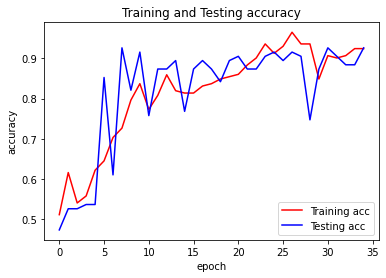

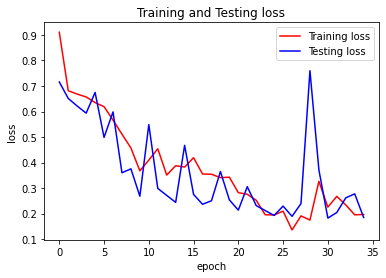

In [13]:
# plot history
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Testing acc')
plt.title('Training and Testing accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Testing loss')
plt.title('Training and Testing loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [14]:
print(model.metrics_names)
model.evaluate(testing_set)

['loss', 'binary_accuracy']
95/95 [==============================] - 1s 10ms/step - loss: 0.1847 - binary_accuracy: 0.9263


[0.1846720576286316, 0.9263157844543457]

In [15]:
training_set.class_indices

{'identity_card': 0, 'passport': 1}

In [18]:
saved_model_path = "./my_model.h5"
model.save(saved_model_path)

In [19]:
! tensorflowjs_converter --input_format=keras {saved_model_path} "./"

2022-01-25 12:17:11.991934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-01-25 12:17:11.991983: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [24]:
from keras.preprocessing import image
import numpy as np

test_image = image.load_img(r"C:\Users\joshu\Desktop\imageClassifier\dataset\single_prediction\test passport 2.jpg", target_size = INPUT_SHAPE)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

if result[0][0] == 1:
    prediction = 'Passport'
else:
    prediction = 'ID'

print(prediction)

Passport


In [23]:
from keras.preprocessing import image
import numpy as np

test_image = image.load_img(r"C:\Users\joshu\Desktop\imageClassifier\dataset\single_prediction\test ic.jpg", target_size = INPUT_SHAPE)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

if result[0][0] == 1:
    prediction = 'Passport'
else:
    prediction = 'ID'

print(prediction)

ID
